# Lab 7 - Uczenie maszynowe

Wczytanie niezbędnych pakietów. Na potrzeby ćwiczenia wykorzystany zostaną pakiety `openCV`, `scikit-image` oraz pakiet uczenia maszynowego `scikit-learn`.

In [8]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2


import skimage.measure as sime
import skimage.morphology as simo
import skimage.color as sic

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import tree

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

Dla uproszczenia składni wprowadzimy funkcje pomocnicze.

In [9]:
#FUNKCJE POMOCNICZE

# funkcja wyswietlająca obraz kolorowy lub w skali szarości
def pobr_cv2(obraz, tytul = '', osie = False, opencv = True, colmap = 'gray'):
    if not(osie):
        plt.axis("off") 
    if obraz.ndim == 2:
        plt.imshow(obraz,cmap = colmap,interpolation = 'none')
    else:
        if opencv:
            plt.imshow(cv2.cvtColor(obraz,cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(obraz)
    plt.title(tytul)

# funkcja wyświetlająca obrazy wg. listy
def pobr(listaobr, ile_k = 1, listatyt = [], opencv = True, wart_dpi = 100, osie = False, colmap = 'gray'):
    rozm_obr = 5
    ile = len(listaobr)
    if len(listatyt) == 0:
        listatyt = [' ']*ile
    ile_w = np.ceil(ile / ile_k).astype(int)
    figsize_k = rozm_obr*ile_k
    figsize_w = rozm_obr*ile_w
    plt.figure(figsize=(figsize_k,figsize_w), dpi = wart_dpi)
    for i in range(0,ile):
        if isinstance(listaobr[i],np.ndarray):
            plt.subplot(ile_w,ile_k,i+1)
            pobr_cv2(listaobr[i],listatyt[i],osie,opencv, colmap)
    plt.show()

## 1. Etap przygotowawczy

Zaczniemy od wczytania obrazu testowego, zawierającego obiekty nalezące do 6 różnych klas.

In [10]:
# wczytanie obrazu
o = cv2.imread("obiekty.png")
b = o[:,:,1]>0
# etykietowanie
etykiety = label(b)
pobr([o,b,etykiety],3)
# wyznaczanie cech
cechy = regionprops(etykiety)

TypeError: 'NoneType' object is not subscriptable

Następnie wykonane zostanie etykietowanie oraz wyznaczenie cech.

W kolejnym kroku wybieramy podzbiór cech oraz umieszczmy te cechy w macierzy numpy. W kolumnach tej macierzy zapisane są wartości wybranych cech (wg. listy). Wiersze odpowiadają obiektom. Etykieta obiektu którego wartości cech dany wiersz zawiera jest równa numerowi wiersza plus 1 (inaczej niż w przykładzie pokazanym w Lab6): cechy obiektu o etykiecie 1 sa zapisane w wierszu o indeksie 0. 

W wektorze kategorie zapisywane są numery kategorii poszczególnych obiektów:

    1. zaokrąglona gwiazda
    2. strzałka
    3. prostokąt z otworem
    4. owal z otworem
    5. prostokąt bez otworu
    6. owal bez otworu

In [4]:
# ekstrakcja cech
# wyszukiwanie kolorów
kolory = np.unique(o.reshape(-1, o.shape[2]), axis=0) # kolory w obrazie
kolory = kolory[1:7,:] # usuwa kolor tła
print(kolory)
ile_obiektow = len(cechy)
ile_kategorii = len(kolory)
lista_cech = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity']
ile_cech = len(lista_cech)
tabela_cech = np.zeros((ile_obiektow,ile_cech+1))
kategorie = np.zeros((ile_obiektow,1))
for i in range(0,ile_obiektow):
    for j in range(0,ile_cech):
        tabela_cech[i,j] = cechy[i][lista_cech[j]]
    x,y = cechy[i]['Coordinates'][1] # wsp. jednego z punktów obiektu - do próbkowania koloru
    for k in range(0,ile_kategorii):
        if list(o[x,y,:]) == list(kolory[k]):
            break;
    kategorie[i] = k 
tabela_cech[:,ile_cech] = tabela_cech[:,3]/tabela_cech[:,2]
tabela_cech[:,0] = (tabela_cech[:,0] == 1) # korekta liczby Eulera

[[  6   9 209]
 [  9 168  57]
 [ 34 191 236]
 [160  11   8]
 [189   8 141]
 [189 175   8]]


Wizualizacja obiektów spełniających kryteria odnoszące się do cech. Z macierzy cech wybieramy jedynie te obiekty, dla których odpowiednia cecha ma określoną wartość. 

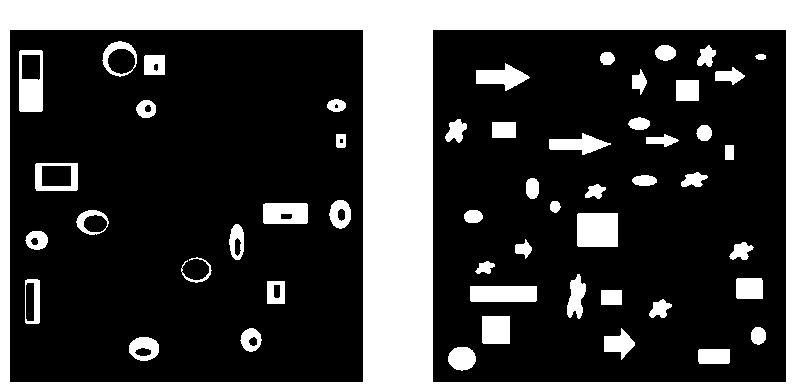

In [5]:
# atrybut nr 0 - liczba Eulera
euler_0 = np.where(tabela_cech[:,0] == 0) + np.array(1) # 0 - z otworami
euler_1 = np.where(tabela_cech[:,0] == 1) + np.array(1) # 1 - bez otworów
otwory = [np.where(np.isin(etykiety,euler_0),255,0), np.where(np.isin(etykiety,euler_1),255,0)]
pobr(otwory,2)

W analogiczny sposób możemy wybierać obiekty należące do określnoej kategorii. 

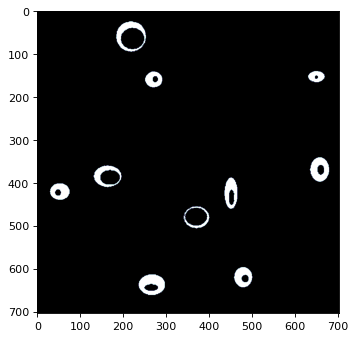

In [166]:
lista_ob = np.where(kategorie == 6)
wynik = np.where(np.isin(etykiety,lista_ob[0] + 1),255,0)
plt.figure(figsize=(5,5), dpi = 80)
plt.imshow(wynik, 'bone')
plt.show()

Przykład poniżej pokazuje wizualizacja kategorii poprzez kolory - kolory są zbliżone do oryginalnych (tak zostały dobrane), ale zostały przypisane na podstawie danych o kategorii danego obiektu.

<Figure size 400x400 with 0 Axes>

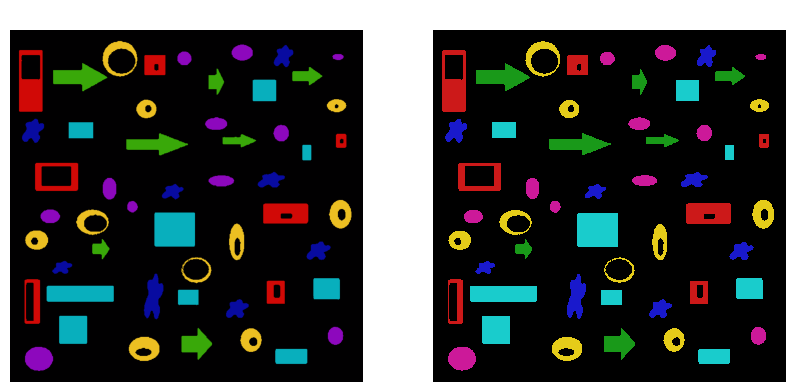

In [167]:
lista_ob = np.where(kategorie == 1)
obraz_et = np.where(np.isin(etykiety,lista_ob[0] + 1),1,0)
for i in range(2,7):
    lista_ob = np.where(kategorie == i) 
    wynik = np.where(np.isin(etykiety,lista_ob[0] + 1),i,0)
    obraz_et = obraz_et + wynik
plt.figure(figsize=(5,5), dpi = 80)
kol = np.array([[0.0, 0.0, 0.0, 1.0], [0.1, 0.1, 0.8, 1.0], [0.1, 0.6, 0.1, 1.0], [0.8, 0.1, 0.1, 1.0],[0.1, 0.8, 0.8, 1.0],  
                  [0.8, 0.1, 0.6, 1.0],[0.9, 0.8, 0.1, 1.0]])
nowykol = mpl.colors.ListedColormap(kol)
#plt.imshow(obraz_et,cmap = nowykol,interpolation = 'none')
#plt.show()
pobr([o, obraz_et],2,colmap = nowykol)

Dla uproszczenia kodów w dalszej cześci ćwiczenia trzy powyżej opisane operacje zostana zapisane w formie funkcji

In [168]:
# funkcja generująca tabelę cech

def wyznacz_tab_cech(cechy):
    lista_cech = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity']
    ile_obiektow = len(cechy)
    ile_cech = len(lista_cech)
    tabela_cech = np.zeros((ile_obiektow,ile_cech+1))
    for i in range(0,ile_obiektow):
        for j in range(0,ile_cech):
            tabela_cech[i,j] = cechy[i][lista_cech[j]]
    tabela_cech[:,ile_cech] = tabela_cech[:,3]/tabela_cech[:,2]
    tabela_cech[:,0] = (tabela_cech[:,0] == 1) # korekta liczby Eulera
    return tabela_cech

# funkcja generująca tablicę kategorii na podstawie kolorów na obrazie oryginalnym

def wyznacz_tab_kategorii(o,cechy):
    # ekstrakcja cech
    kolory = [[160,11,8], # granatowy
          [9,168,57], # zielony
          [6,9,209], # czerwony
          [189,175,8], # niebieski
          [189,8,141], # fioletowy
          [34,191,236]] # żółty
    ile_obiektow = len(cechy)
    ile_kategorii = len(kolory)
    kategorie = np.zeros((ile_obiektow,1))
    for i in range(0,ile_obiektow):
        x,y = cechy[i]['Coordinates'][1] # wsp. jednego z punktów obiektu - do próbkowania koloru
        for k in range(0,ile_kategorii):
            if list(o[x,y,:]) == kolory[k]:
                break;
        kategorie[i] = k + 1
    return kategorie

# funkcja wyświetlająca obraz z naniesionymi kolorami odpowiadającymi kolejnym etykietom

def okat(obr_etyk, kat_obiektow, tytul = "kategorie"):
    lista_ob = np.where(kat_obiektow == 1)
    obraz_et = np.where(np.isin(obr_etyk,lista_ob[0] + 1),1,0)
    for i in range(2,7):
        lista_ob = np.where(kat_obiektow == i) 
        wynik = np.where(np.isin(obr_etyk,lista_ob[0] + 1),i,0)
        obraz_et = obraz_et + wynik
    plt.figure(figsize=(5,5), dpi = 80)
    kol = np.array([[0.0, 0.0, 0.0, 1.0], [0.1, 0.1, 0.8, 1.0], [0.1, 0.6, 0.1, 1.0], [0.8, 0.1, 0.1, 1.0],[0.1, 0.8, 0.8, 1.0],  
                  [0.8, 0.1, 0.6, 1.0],[0.9, 0.8, 0.1, 1.0]])
    nowykol = mpl.colors.ListedColormap(kol)
    pobr([obraz_et],1,[tytul],colmap = nowykol)

<Figure size 400x400 with 0 Axes>

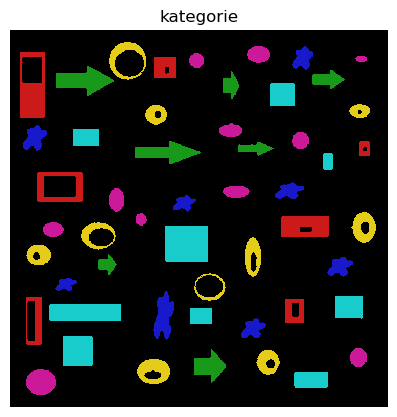

In [59]:
# wykorzystanie funkcji

tabela_cech = wyznacz_tab_cech(cechy)
kategorie = wyznacz_tab_kategorii(o,cechy)
okat(etykiety, kategorie)

Macierz wykresów punktowych pozwala na wizaualizację dystrybucji obiektów w przestrzeni cech. Przykład poniżej pokazuje macierz wykresów punktowych dla wszystkich rozpatrywanych cech.

   EulerNumber    Area  BoundingBoxArea  FilledArea  Extent  EquivDiameter  \
1         0.00 1705.00          4970.00     3819.00    0.34          46.59   
2         1.00 1050.00          1344.00     1050.00    0.78          36.56   
3         1.00 1041.00          1716.00     1041.00    0.61          36.41   
4         0.00 4008.00          5781.00     5777.00    0.69          71.44   
5         1.00  609.00           756.00      609.00    0.81          27.85   

   Solidity  ExtentNoHoles  kategoria  
1      0.44           0.77          6  
2      0.98           0.78          5  
3      0.83           0.61          1  
4      0.69           1.00          3  
5      0.98           0.81          5  


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

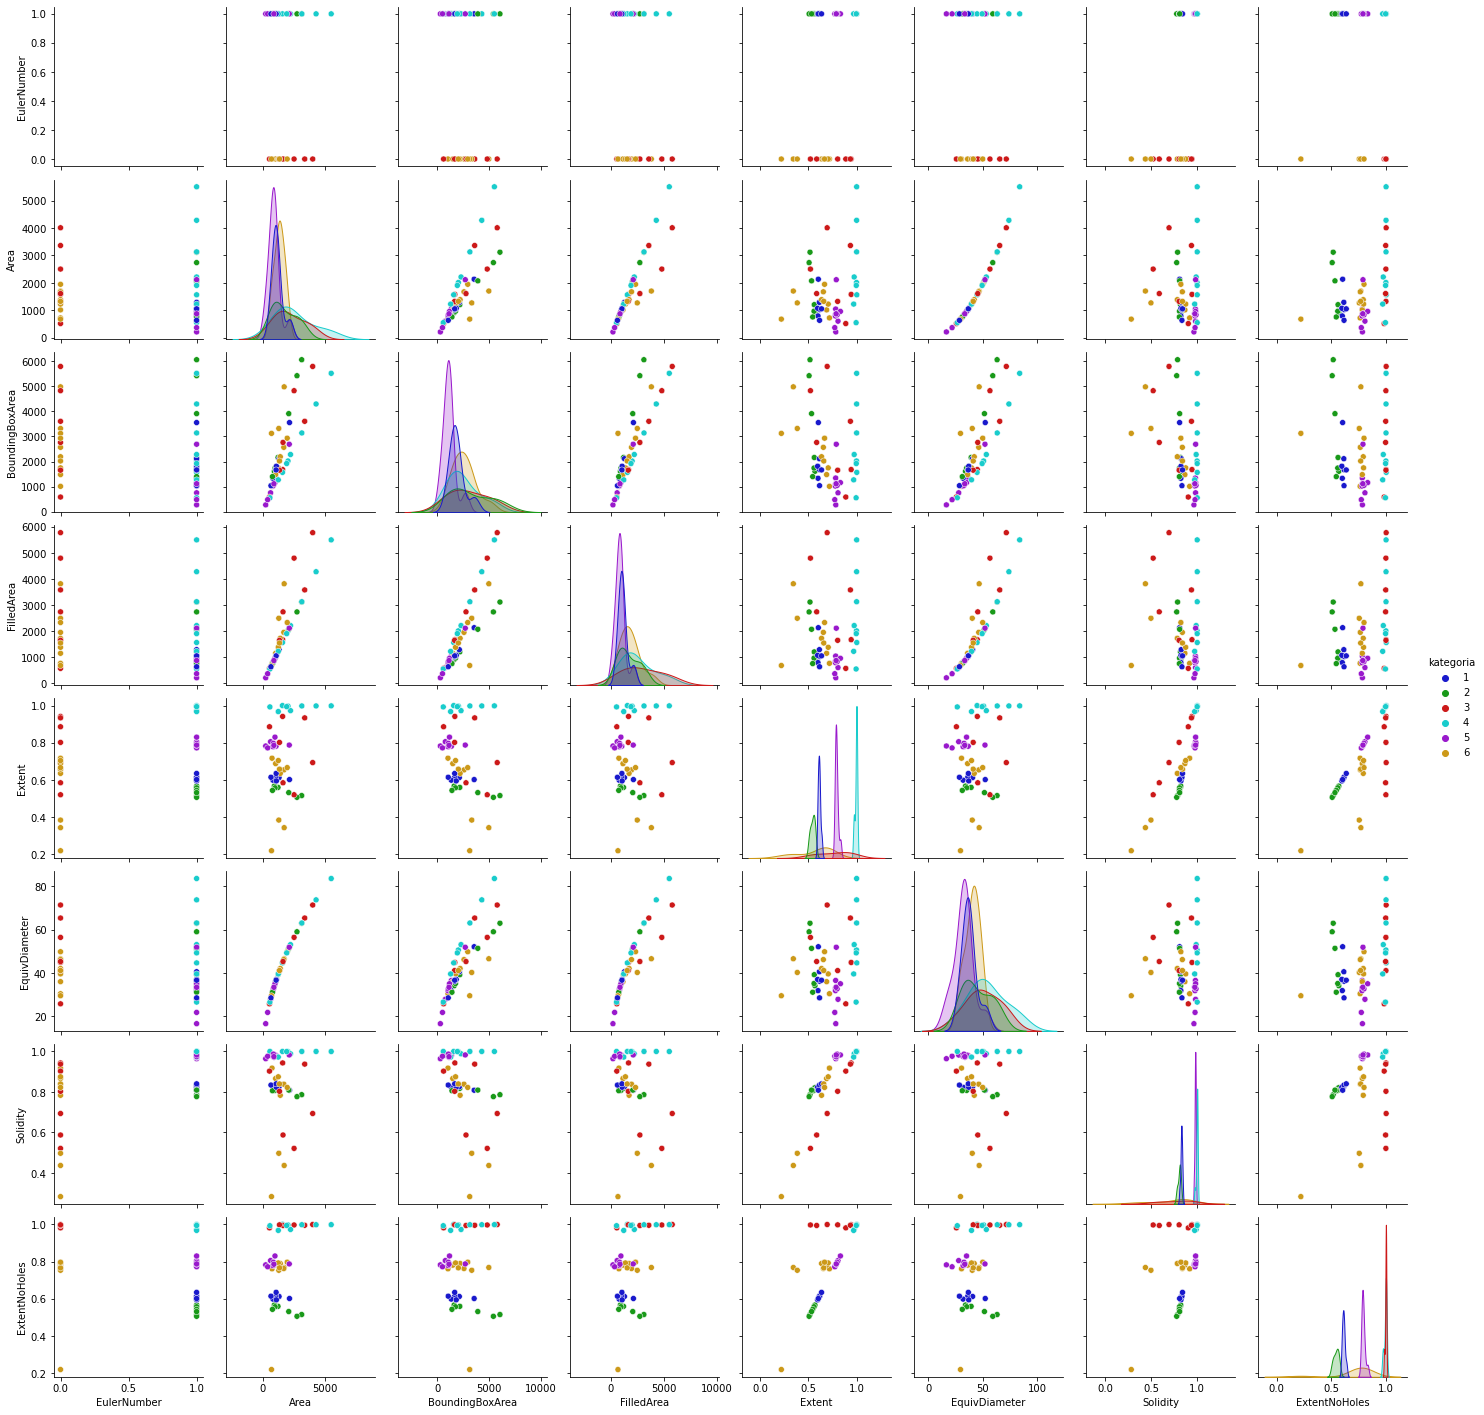

In [169]:
dane = pd.DataFrame(tabela_cech,index = list(range(1,tabela_cech.shape[0]+1)),columns = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity','ExtentNoHoles'])
dane['kategoria'] = kategorie.astype(np.int)
print(dane.head())
pal = ["#1919cc","#199919","#cc1919", "#19cccc", "#9919cc", "#cc9919"]
sns.pairplot(dane, kind="scatter", hue = 'kategoria', palette = pal)

> **Pytanie** Które cechy lepiej separują klasy, a które - gorzej ?

Poniższa procedura genruje nową tabele cech zawierającą jedynie wybrane cechy, umieszczone na liście (z numerami cech).

In [173]:
def wybierz(tabela_cech,lista_cech):
    wybrane =  np.zeros((tabela_cech.shape[0],len(lista_cech)))
    for i in range(0,len(lista_cech)):
        wybrane[:,i] = tabela_cech[:,lista_cech[i]]
    return wybrane

In [174]:
naj = wybierz(tabela_cech,[0,4,7])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

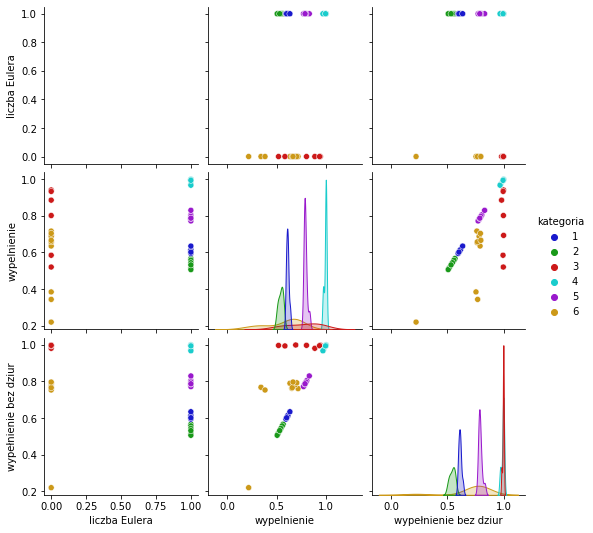

In [175]:
dane_naj = pd.DataFrame(naj,index = list(range(1,naj.shape[0]+1)),columns = ['liczba Eulera','wypelnienie','wypełnienie bez dziur'])
dane_naj['kategoria'] = kategorie.astype(np.int)
dane_naj.head()
pal = ["#1919cc","#199919","#cc1919", "#19cccc", "#9919cc", "#cc9919"]
sns.pairplot(dane_naj, kind="scatter", hue = 'kategoria', palette = pal)

Dla uproszczenia utworzona zostanie procedura rysująca macierz wykresów punktowych dla podzbioru cech.

In [176]:
from operator import itemgetter 
def mwp(cechy_wszystkie, lista_cech, kategorie):
    nazwy_cech = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity','ExtentNoHoles']
    krotka_lista_cech = list(itemgetter(*lista_cech)(nazwy_cech))
    cechy = wybierz(cechy_wszystkie, lista_cech)
    dane = pd.DataFrame(cechy,index = list(range(1,cechy.shape[0]+1)), columns = krotka_lista_cech )
    dane['kat'] = kategorie.astype(np.int)
    #print(dane.head())
    pal = ["#1919cc","#199919","#cc1919", "#19cccc", "#9919cc", "#cc9919"]
    sns.pairplot(dane, vars = krotka_lista_cech, kind="scatter", hue = 'kat', palette = pal)

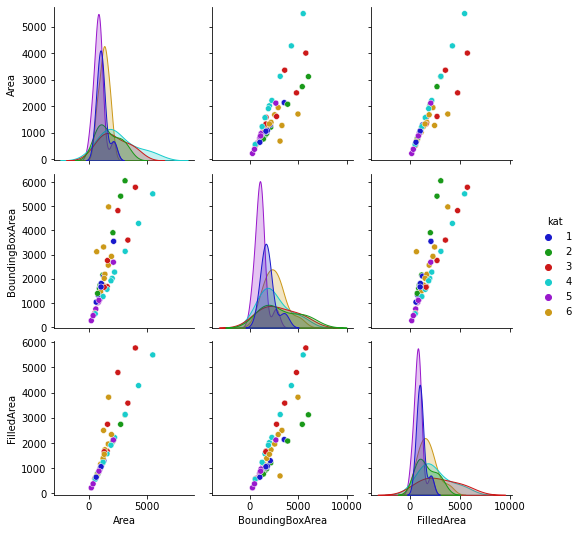

In [178]:
wybrane_cechy = [1,2,3]
mwp(tabela_cech,wybrane_cechy, kategorie)

## 2. Klasyfikacja

Dane otrzymane na wcześniejszych etapach - cechy i kategorie zostaną wykorzystane do zbudowania modelu klasyfikacji. Proces modelowania klasyfikatora wymaga podziału zbioru na uczący i testowy. W tym przypadku, dotychczas rozpatrywany obraz potraktujemy jako zbiór uczący, inny zaś obraz będzie zbiorem testowy. 

Model klasyfikatora najbliższego sąsiada (1-NN)

In [180]:
wybrane_cechy = [0,1,2]
naj = wybierz(tabela_cech,wybrane_cechy)
model = KNeighborsClassifier(n_neighbors=1)
model.fit(naj,np.ravel(kategorie))

KNeighborsClassifier(n_neighbors=1)

Klasyfikacja obiektów ze zbioru uczącego.

In [181]:
klasy_przewidywane = model.predict(naj)

<Figure size 400x400 with 0 Axes>

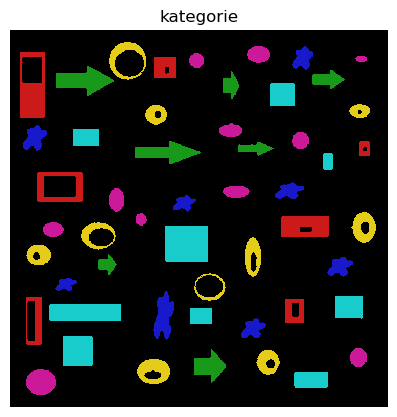

In [182]:
okat(etykiety,klasy_przewidywane)

Macierz pomyłek pokazuje pełną zgodność (co jest oczywiste)

In [183]:
confusion_matrix(klasy_przewidywane,kategorie)

array([[ 8,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0, 11,  0],
       [ 0,  0,  0,  0,  0, 10]], dtype=int64)

Zbiór testowy to obraz `obiekty2.png` - on nie był wykorzystywane do budowy modelu klasyfikacji. W tym zbiorze jednak każdy obiekt jest opisany - wiadomo do jakiej klasy należy, wiedzę o klasie wykorzystamy do weryfikacji modelu klasyfikatora. 

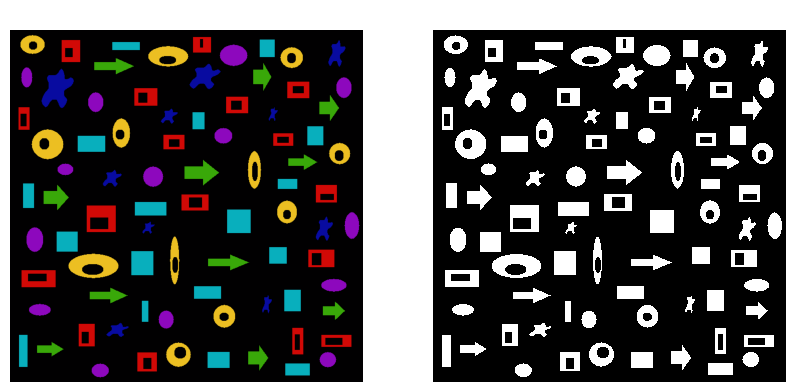

In [187]:
o2 = cv2.imread("obiekty2.png")
b2 = o2[:,:,1]>0
pobr([o2,b2],2)

Generujemy tabelę cech dla drugiego obrazu, następnie wybieramy te same cechy, które zostały wybrane w zbiorze uczącym.

In [188]:
etykiety2 = label(b2)
cechy2 = regionprops(etykiety2)
# tabela cech dla zbioru testowego
tabela_cech2 = wyznacz_tab_cech(cechy2)
kategorie2 = wyznacz_tab_kategorii(o2,cechy2)
# wybrane "najlepsze" cechy
naj2 = wybierz(tabela_cech2,wybrane_cechy)

Zapominamy na chwilę o klasach. I uruchamiamy klasyfikator do wyznaczenia klasy dla każdego obiektu

In [189]:
klasy_przewidywane2 = model.predict(naj2)

Wynik jest nieco inny niż oryginalny.

<Figure size 400x400 with 0 Axes>

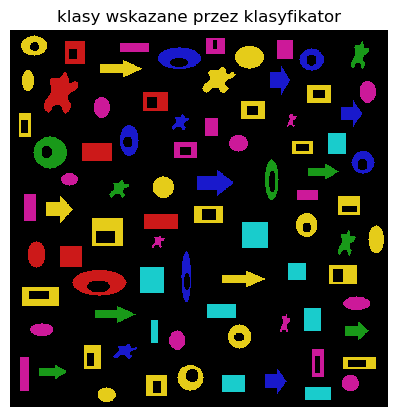

In [190]:
okat(etykiety2,klasy_przewidywane2,"klasy wskazane przez klasyfikator")

Potwierdza to macierz pomyłek.

In [191]:
confusion_matrix(klasy_przewidywane2,kategorie2)

array([[ 2,  4,  0,  0,  0,  5],
       [ 3,  4,  0,  0,  0,  2],
       [ 1,  0,  2,  3,  1,  1],
       [ 0,  0,  0,  9,  0,  0],
       [ 3,  0,  3,  6,  8,  0],
       [ 1,  3, 12,  0,  5,  4]], dtype=int64)

Docelowo klasyfikator pracuje na danych nieskategoryzowanych. Dla symulacji tego etapu działania wykorzystamy obraz `obiekty3.png`, który zawiera obiekty ale bez przypisanych im kategorii (kolorów). Na zbiorze tym zostanie teraz przetestowany klasyfikator.

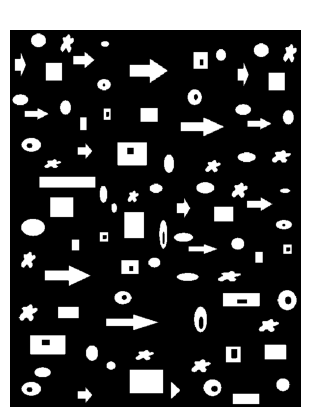

<Figure size 400x400 with 0 Axes>

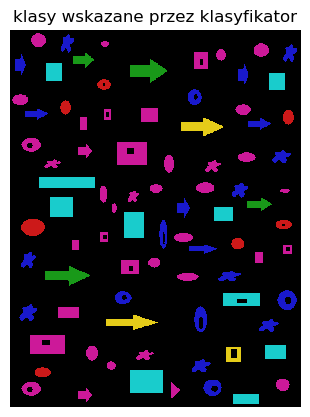

In [192]:
o3 = cv2.imread("obiekty3.png")
b3 = o3[:,:,1]>0
pobr([o3])
etykiety3 = label(b3)
cechy3 = regionprops(etykiety3)
tabela_cech3 = wyznacz_tab_cech(cechy3)
naj3 = wybierz(tabela_cech3,wybrane_cechy)
klasy_przewidywane3 = model.predict(naj3)
okat(etykiety3,klasy_przewidywane3,"klasy wskazane przez klasyfikator")

Cały proces testowania zostanie teraz zapisany w pojedynczej funkcji.

In [193]:
def testuj(model,wybrane_cechy,czy_mwp = True):
    o = cv2.imread("obiekty.png")
    b = o[:,:,1]>0
    etykiety = label(b)
    cechy = regionprops(etykiety)
    tabela_cech = wyznacz_tab_cech(cechy)
    kategorie = wyznacz_tab_kategorii(o,cechy)    
    if czy_mwp: mwp(tabela_cech,wybrane_cechy,kategorie)    
    naj = wybierz(tabela_cech,wybrane_cechy)
    okat(etykiety,kategorie,"zbiór uczący - oryginalny podział na kategorie") 
    model.fit(naj,np.ravel(kategorie))
    klasy_przewidywane = model.predict(naj)
    okat(etykiety,klasy_przewidywane,"zbiór uczący - wynik klasyfikacji") 
    print(confusion_matrix(klasy_przewidywane,kategorie))
    o2 = cv2.imread("obiekty2.png")
    b2 = o2[:,:,1]>0
    etykiety2 = label(b2)
    cechy2 = regionprops(etykiety2)
    tabela_cech2 = wyznacz_tab_cech(cechy2)
    kategorie2 = wyznacz_tab_kategorii(o2,cechy2)
    okat(etykiety2,kategorie2,"zbiór testowy - oryginalny podział na kategorie")
    naj2 = wybierz(tabela_cech2,wybrane_cechy)
    klasy_przewidywane2 = model.predict(naj2)
    okat(etykiety2,klasy_przewidywane2,"zbiór testowy - wynik klasyfikacji") 
    print(confusion_matrix(klasy_przewidywane2,kategorie2))
    o3 = cv2.imread("obiekty3.png")
    b3 = o3[:,:,1]>0
    pobr([o3])
    etykiety3 = label(b3)
    cechy3 = regionprops(etykiety3)
    tabela_cech3 = wyznacz_tab_cech(cechy3)
    naj3 = wybierz(tabela_cech3,wybrane_cechy)
    klasy_przewidywane3 = model.predict(naj3)
    okat(etykiety3,klasy_przewidywane3,"zbiór nieskategoryzowany - wynik klasyfikacji")

Dzięki temu możliwe będzie testowanie dla różnych podzbiorów cech oraz różnych modeli klasyfikatora. 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

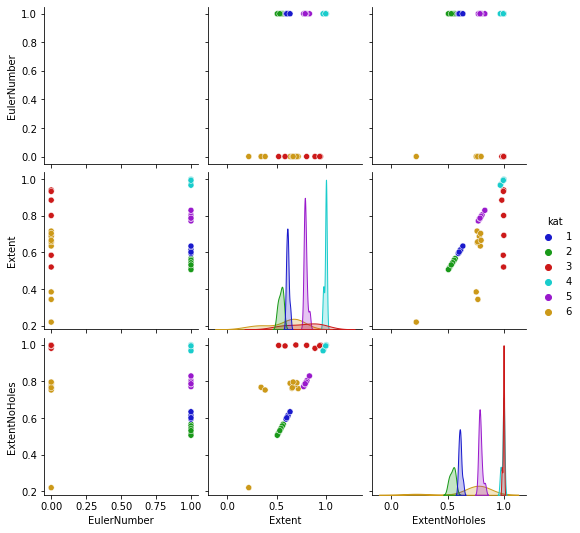

<Figure size 400x400 with 0 Axes>

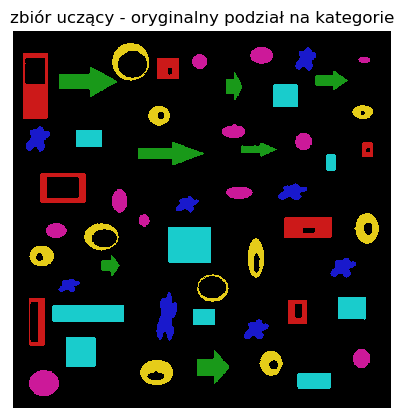

<Figure size 400x400 with 0 Axes>

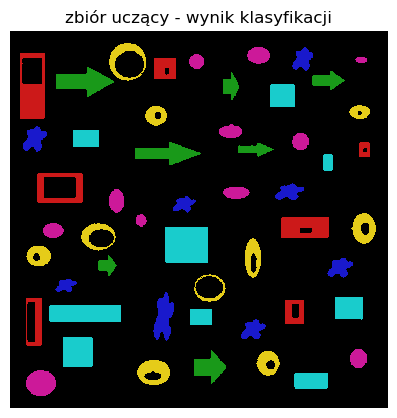

[[ 8  0  0  0  0  0]
 [ 0  7  0  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0 10]]


<Figure size 400x400 with 0 Axes>

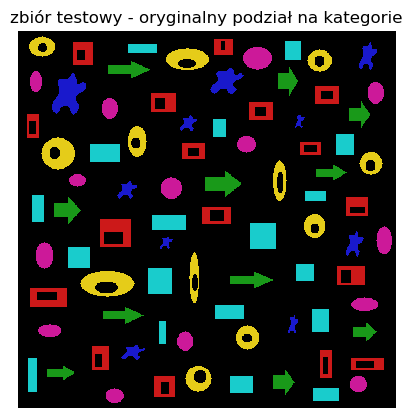

<Figure size 400x400 with 0 Axes>

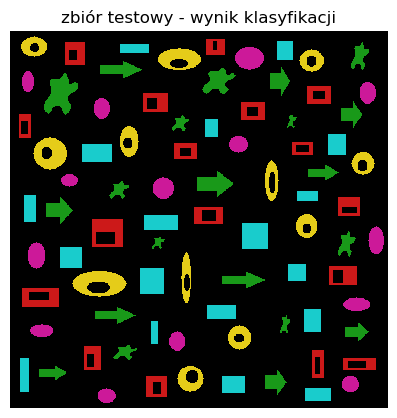

[[ 0  0  0  0  0  0]
 [10 11  0  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  0 18  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  0  0 12]]


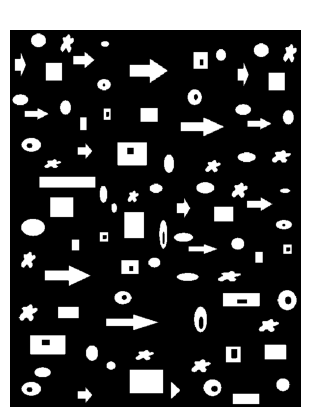

<Figure size 400x400 with 0 Axes>

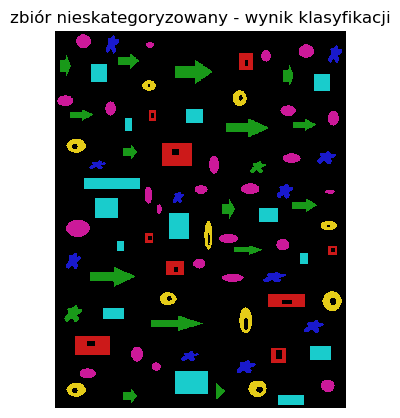

In [195]:
# przykładowy test 
wybrane_cechy = [0,4,7] 
# klasyfikator k-NN k=3
model = KNeighborsClassifier(n_neighbors=3)
testuj(model,wybrane_cechy)

<Figure size 400x400 with 0 Axes>

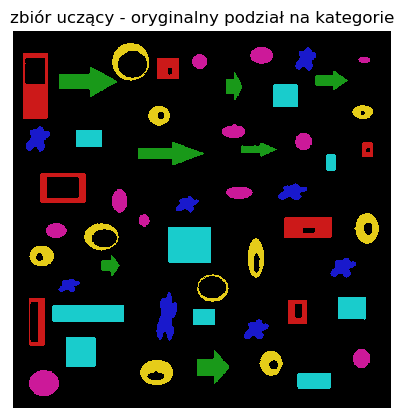

<Figure size 400x400 with 0 Axes>

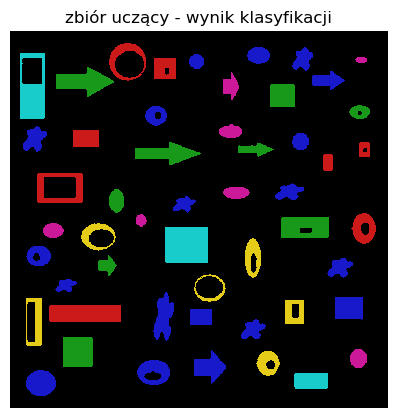

[[8 2 0 2 4 3]
 [0 4 1 2 1 1]
 [0 0 3 3 0 2]
 [0 0 1 2 0 0]
 [0 1 0 0 6 0]
 [0 0 2 0 0 4]]


<Figure size 400x400 with 0 Axes>

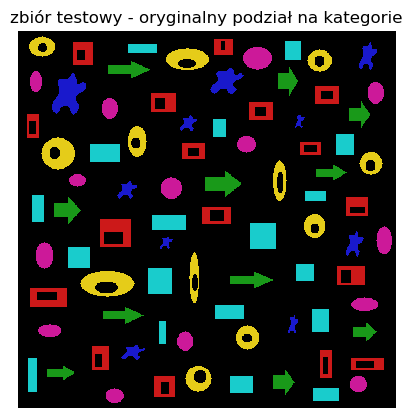

<Figure size 400x400 with 0 Axes>

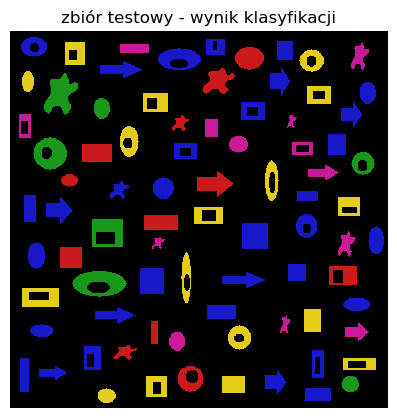

[[ 1  8  5 10  6  3]
 [ 1  0  1  0  2  3]
 [ 3  1  1  4  2  1]
 [ 0  0  0  0  0  0]
 [ 5  2  2  2  2  0]
 [ 0  0  8  2  2  5]]


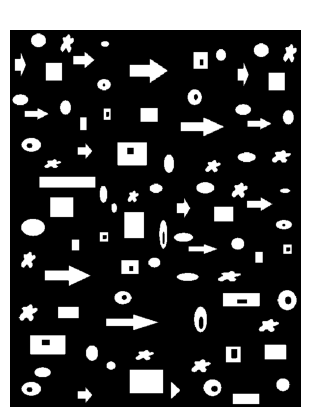

<Figure size 400x400 with 0 Axes>

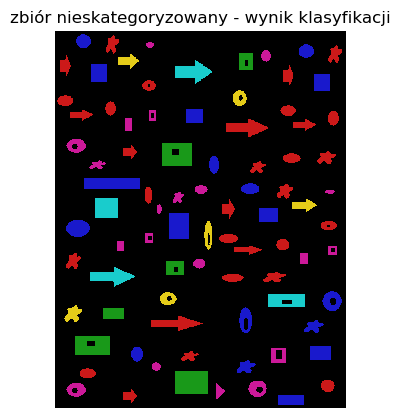

In [196]:
# przykładowy test dla innego zestwu cech
wybrane_cechy = [1,3,5] 
# klasyfikator k-NN k=3
model = KNeighborsClassifier(n_neighbors=3)
testuj(model,wybrane_cechy,False) # False oznacza, że nie wyświetlamy mwp

> **Zadanie** Przestuj różne zestawy cech i różne klasyfikatory:
* k-NN dla różnych wartości k
* najbliższy prototyp (`NearestCentroid()`)
* Bayesa (`GaussianNB()`)
* drzewo decyzyjne (`tree.DecisionTreeClassifier(max_depth=4)`)

Jak wyniki klasyfikacji dla poszczególnych kombinacji cech możemy odnieść do wniosków z obserwacji macierzy wykresów punktowych. 

> **Zadanie** Obraz `cyfry.png` zawiera 10 różnych obiektów - cyfr od 0 do 9. Wyznacz cechy tych obiektów i spróbuj znaleźć zestaw cech, który umożliwiłby rozóżnienie tych cyfr. Zaproponuj model klasyfikatora oraz przetestuj go na obrazach `cyfry1.png`, `cyfry2.png` i `cyfry3.png`. 

---
---
Historia zmian:
* wersja pierwotna r.akad 19/20: 14.05.2020 (MI)
* wersja ADOM r.akad. 20/21: 25.11.2020 (MI)